# Análisis de serie de tiempo de datos de covid en México

Notebook dedicado al análisis de serie de tiempo de datos de covid-19 en México, a nivel nacional y estatal

In [1]:
# Librerías para el tratamiento de datos y graficar
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import itertools
from scipy import stats
from scipy import fftpack

El análisis se hizo empleando modelos autorregresivos con la librería statsmodels

In [2]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [3]:
from pmdarima import auto_arima

In [4]:
#Se importó también el regresor de Random Forest de la librería scikit learn.
#También se importaron las métricas del error medio absoluto y cuadrado
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import *

In [5]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Los datos de covid-19 se encuentran guardados en un repositorio de git-hub, que se tomaron de la página oficial de la secretaría de salud. Los datos en el repositorio se han editado en python y en excel.

In [6]:
path =  'C:\\Users\jose_\Desktop\Escuela de verano'
datos_total = pd.read_csv(path + "\datos_covid\casos_total.csv", sep = ',')
datos_total.head()

,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,...,2021-09-08,2021-09-09,2021-09-10,2021-09-11,2021-09-12,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17
0,0,0,0,0,0,0,0,0,0,0,...,91,87,107,28,19,131,65,12,2,0
1,0,0,0,0,0,0,0,0,0,0,...,145,130,96,40,39,161,80,30,11,0
2,0,0,0,0,0,0,0,0,0,0,...,60,58,41,21,22,66,54,19,10,0
3,0,0,0,0,0,0,0,0,0,0,...,130,130,83,39,28,103,52,15,6,0
4,0,0,0,0,0,0,0,0,0,0,...,70,70,78,43,32,89,55,14,8,0


In [7]:
datos_total.describe()

,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,...,2021-09-08,2021-09-09,2021-09-10,2021-09-11,2021-09-12,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17
count,33.0,33.000000,33.0,33.0,33.0,33.0,33.000000,33.0,33.000000,33.000000,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.0,0.060606,0.0,0.0,0.0,0.0,0.060606,0.0,0.060606,0.303030,...,667.090909,638.121212,589.696970,249.393939,184.121212,646.727273,429.393939,204.060606,42.060606,0.727273
std,0.0,0.242306,0.0,0.0,0.0,0.0,0.242306,0.0,0.242306,1.015038,...,1885.159432,1808.290228,1673.315113,712.519076,519.000046,1831.378481,1221.383333,589.508532,119.122033,2.308581
min,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,60.000000,58.000000,41.000000,16.000000,17.000000,66.000000,36.000000,12.000000,1.000000,0.000000
25%,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,137.000000,129.000000,107.000000,49.000000,39.000000,131.000000,80.000000,30.000000,8.000000,0.000000
50%,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,217.000000,198.000000,203.000000,92.000000,79.000000,230.000000,137.000000,65.000000,12.000000,0.000000
75%,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,460.000000,462.000000,368.000000,159.000000,124.000000,368.000000,302.000000,113.000000,25.000000,0.000000
max,0.0,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,5.000000,...,11007.000000,10529.000000,9730.000000,4115.000000,3038.000000,10671.000000,7085.000000,3367.000000,694.000000,12.000000


Las filas del data frame son los estados de México y las columnas son las fechas, con casos actualizados cada día. Los casos a nivel nacional se encuentran en la última fila de los datos

In [8]:
casos_nacional = datos_total.iloc[[-1]]

Ahora hacemos el tratamiento de datos correspondiente. Usamos la función melt para hacer una tabla pivot vertical y cambiamos el índice a la fecha para tener la serie de tiempo.

In [9]:
casos_nacional = pd.melt(casos_nacional, var_name = "Fecha", value_name = "Casos")
casos_nacional["Fecha"] = pd.to_datetime(casos_nacional["Fecha"])
casos_nacional = casos_nacional.set_index("Fecha")
casos_nacional = casos_nacional["Casos"]
casos_nacional.head()

Fecha
2020-02-18    0
2020-02-19    1
2020-02-20    0
2020-02-21    0
2020-02-22    0
Name: Casos, dtype: int64

2021-10-27 18:23:38,001 numexpr.utils INFO  Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-10-27 18:23:38,003 numexpr.utils INFO  NumExpr defaulting to 8 threads.


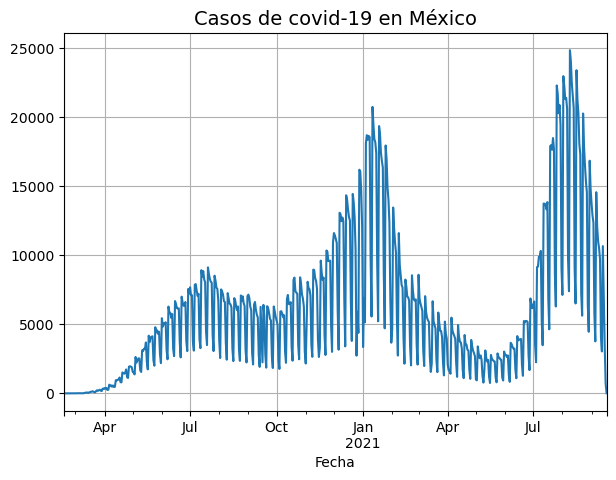

In [10]:
plt.figure(figsize=(7,5),dpi=100)
casos_nacional.plot()
plt.grid()
plt.title("Casos de covid-19 en México", fontsize = 14)
plt.savefig("casos_nacional.png")

<BarContainer object of 578 artists>

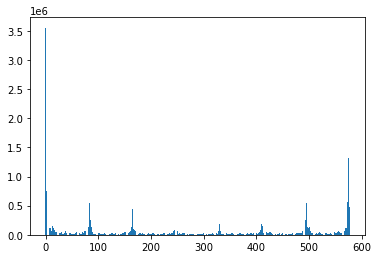

In [58]:
# Frequency and sampling rate
f = 10 # frequency
Fs = 578 # sampling rate
t = np.arange(0,Fs)
y_fft = fftpack.fft(casos_nacional)
plt.bar(t,np.abs(y_fft))

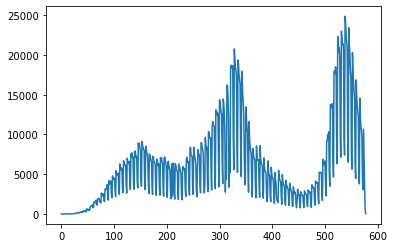

In [15]:
inv = fftpack.ifft(y_fft)
plt.plot(t,inv)

Como podemos observar en la gráfica de casos de covid-19 a nivel nacional los datos presentan un comportamiento aleatorio hasta cierto punto. Esta inestabilidad se debe a la semana laboral, en los fines de semana se recaban bastante menos datos que durante la semana. Por ello, introducimos una media de móvil.

In [11]:
X_sma = casos_nacional.rolling(window = 7).mean().dropna()
X_sma.head()

Fecha
2020-02-24    0.285714
2020-02-25    0.285714
2020-02-26    0.285714
2020-02-27    1.000000
2020-02-28    1.428571
Name: Casos, dtype: float64

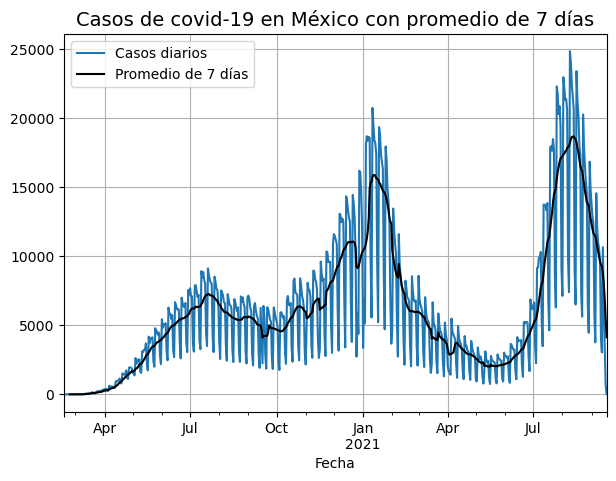

In [13]:
plt.figure(figsize=(7,5),dpi=100)
casos_nacional.plot(label = 'Casos diarios')
X_sma.plot(color = 'black',label = 'Promedio de 7 días')
#casos_nacional.rolling(window = 5).mean().dropna().plot()
plt.grid()
plt.legend()
plt.title("Casos de covid-19 en México con promedio de 7 días", fontsize = 14)
plt.savefig("media_movi.pdf")

In [57]:
auto_arima(X_sma[0:150], seasonal = False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -743.608
Date:                Thu, 28 Oct 2021   AIC                           1493.215
Time:                        00:56:32   BIC                           1502.207
Sample:                             0   HQIC                          1496.868
                                - 150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4450      0.085      5.247      0.000       0.279       0.611
ma.L1         -0.9291      0.035    -26.420      0.000      -0.998      -0.860
sigma2      1343.6457    100.655     13.349      0.000    1146.366    1540.926
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                57.28
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):              37.97   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

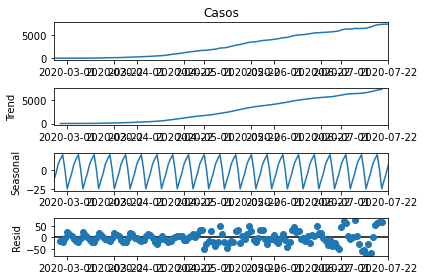

In [54]:
seasonal_decompose(X_sma[:150], model = 'add').plot();

In [18]:
def media_movil_ponderada(datos, period):
    wma = []
    for i in range(len(datos)):
        try:
            weights = np.linspace(1,7,period)
            window = datos[i-period+1:i+1]
            multi = weights*window
            weighted = multi.sum()/weights.sum()
            wma = np.append(wma,weighted)
        except ValueError:
            pass
    return wma

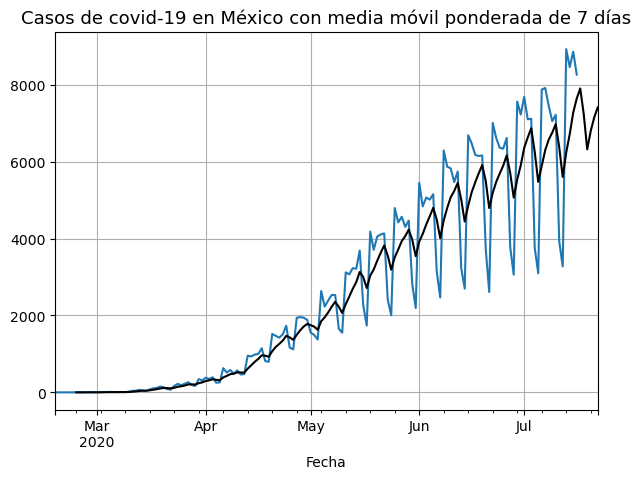

In [19]:
# Calculando la media móvil ponderada
period = 7
X_wma = media_movil_ponderada(casos_nacional, period)
X_wma = pd.Series(X_wma, index = casos_nacional[period-1:].index)

#Graficando los casos de covid con wma
plt.figure(figsize=(7,5),dpi=100)
casos_nacional[0:150].plot()
X_wma[0:150].plot(color = 'black')
#casos_nacional.rolling(window = 5).mean().dropna().plot()
plt.grid()
plt.title(f"Casos de covid-19 en México con media móvil ponderada de {period} días", fontsize = 13)
plt.savefig("media_movi.pdf")

In [20]:
np.linspace(1,7,7)**-1

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14285714])

## Induciendo estacionariedad

Realizamos el test aumentado de Dickey-Fuller para chechar estacionariedad

In [21]:
def adfuller_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [16]:
# Test de Dickey Fuller para los casos de covid-19
adfuller_test(casos_nacional)

ADF Statistic: -2.935066
p-value: 0.041420
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [17]:
#Test de Dickey-Fuller para la media móvil de 7 días de los casos de covid-19
adfuller_test(X_sma)

ADF Statistic: -2.952397
p-value: 0.039585
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


Mientras más negativo sea el valor de la estadística ADF más probabilidad tenemos de que la hipótesis sea rechazada, es decir de que la serie sea estacionaria. Podemos ver que el valor de la estadística ADF es menor al valor crítico en 10%; sin embargo, esto quiere decir que tenemos una probabilidad del 10% de que el resultado sea una coincidencia estadística.

De la gráfica podemos observar que la serie de tiempo de casos de covid en México no es estacionaria. Esto lo podemos comprobar utilizando el gráfico de autocorrelación

<Figure size 700x500 with 0 Axes>

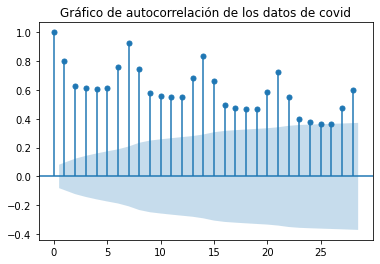

In [18]:
plt.figure(figsize=(7,5),dpi=100)
plot_acf(casos_nacional)
plt.title("Gráfico de autocorrelación de los datos de covid")
plt.savefig("acf_nacional.pdf")

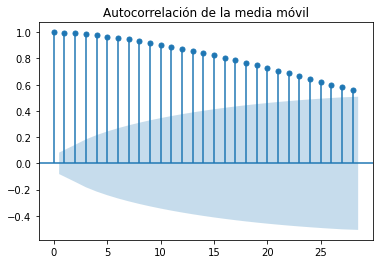

In [19]:
plot_acf(X_sma)
plt.title("Autocorrelación de la media móvil")
plt.savefig("acf_sma.pdf")

Aplicamos una transformación logarítmica para estabilizar la varianza y una diferenciación de primer orden para estabilizar la media de la serie de tiempo. Sin embargo, antes de aplicar la transformación logarítmica es necesario eliminar todos los ceros de la serie.

ADF Statistic: -2.125840
p-value: 0.234252
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


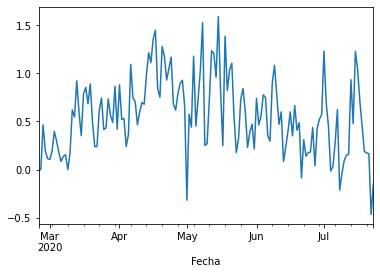

In [90]:
X_dif = np.sqrt(X_sma[X_sma != 0]).diff(periods = 1).dropna()
X_dif[0:150].plot()
adfuller_test(X_dif[0:200])

Fecha
2020-02-27    1.252763
2020-02-28    0.356675
2020-02-29    0.182322
2020-03-01    0.154151
2020-03-02    0.251314
Name: Casos, dtype: float64

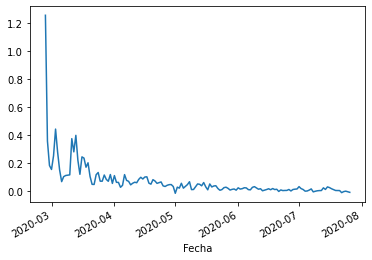

In [170]:
X_log = np.log(X_sma[X_sma != 0])
X_log_sma = X_log.diff(periods = 1).dropna()
X_log_sma = X_log_sma[X_log_sma != 0]
X_log_sma[0:150].plot()
X_log_sma.head()

ADF Statistic: -4.299063
p-value: 0.000446
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


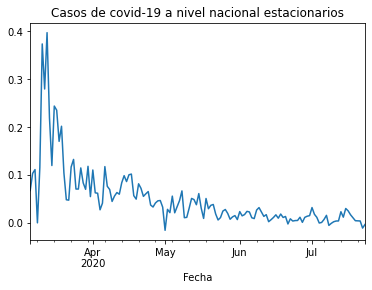

In [92]:
X_log_sma = X_log_sma.drop(X_log_sma.tail(1).index)
#plt.figure(figsize=(7,5),dpi=100)
X_log_sma[10:150].plot()
plt.title("Casos de covid-19 a nivel nacional estacionarios")
plt.savefig("log_casos.pdf")
adfuller_test(X_log_sma[10:150])

Vemos que ahora el valor de la estadística ADF es menor al valor crítico en 1%, por lo tanto, es muy probable que la serie sí tenga un comportamiento estacionario.

<Figure size 700x500 with 0 Axes>

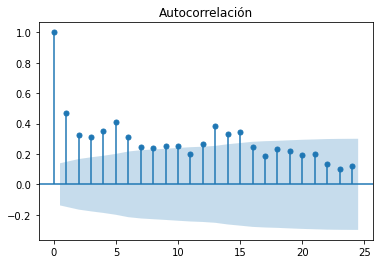

In [93]:
plt.figure(figsize=(7,5),dpi=100)
plot_acf(X_log_sma[0:200])
plt.title("Autocorrelación", fontsize = 12)
plt.savefig("acf_esta.pdf")

In [94]:
# Función de incrementos fraccionales
def incrementos_frac(X):
    Y = []
    for i in range(len(X)-1):
        if (X[i]== 0):
            X[i] = 1
        Y.append((X[i+1]-X[i])/X[i])
    Y = pd.Series(Y, index = X.index[:-1])
    return Y

# Función para regresar a la serie original a partir de una serie con incrementos fraccionales.
# La función lee la serie con incrementos y el primer valor de la serie original
def eliminar_inc(X, x_0):
    x1 = []
    for t in range(len(X)):
        prod = 1
        for i in range(t):
            prod = prod*(X[i]+1)
        x1.append(prod*x_0)
    #x1 = pd.Series(x1, index = X_inc.index)
    return x1

ADF Statistic: -6.166196
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


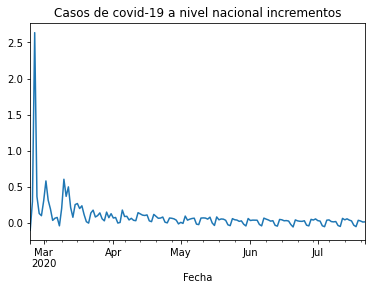

<Figure size 700x500 with 0 Axes>

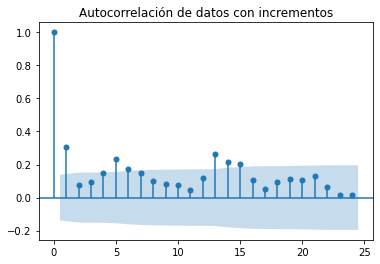

In [97]:
X_inc = incrementos_frac(X_wma)#np.sqrt(X_wma))
X_inc.head()
#plt.figure(figsize=(7,5),dpi=100)
X_inc[0:150].plot()
plt.title("Casos de covid-19 a nivel nacional incrementos")
plt.savefig("inc_casos.pdf")
adfuller_test(X_inc[0:200])

plt.figure(figsize=(7,5),dpi=100)
plot_acf(X_inc[0:200])
plt.title("Autocorrelación de datos con incrementos", fontsize = 12)
plt.savefig("acf_inc.pdf")

ADF Statistic: -6.692673
p-value: 0.000000
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


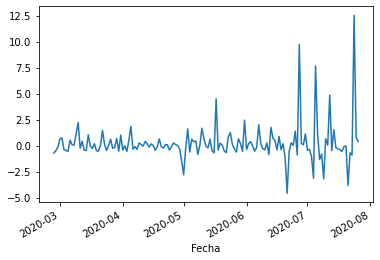

<Figure size 700x500 with 0 Axes>

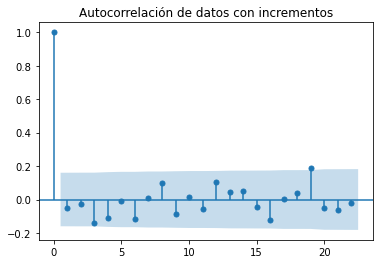

In [171]:
X_inc_log = incrementos_frac(X_log_sma)
X_inc_log[0:150].plot()
adfuller_test(X_inc_log[0:150])

plt.figure(figsize=(7,5),dpi=100)
plot_acf(X_inc_log[0:150])
plt.title("Autocorrelación de datos con incrementos", fontsize = 12)
plt.savefig("acf_inc.pdf")

<AxesSubplot:xlabel='Fecha'>

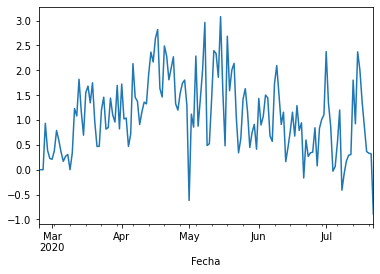

In [260]:
X_box, fitted_lambda = stats.boxcox(X_sma)
X_box = pd.Series(X_box, index = X_sma.index)
X_box[0:150].diff(periods = 1).plot()

## Usando el modelo ARIMA

Creamos una lista de todas las permutaciones posibles para los índices p,d,q del modelo ARIMA utilizando la librería itertools

In [28]:
# Separación de los datos en train y test
# ========================================================
def train_test(datos, steps, plot = False):
    train = datos[:-steps]
    test = datos[-steps:]
    return train, test

Creamos una función para connstruir el modelo ARIMA

In [29]:
# Función para crear y entrenar un modelo AR
def model_AR(datos,steps, plot = True):
    train, test = train_test(datos, steps)
    model_ar = AR(train)
    model_ar_fit = model_ar.fit()
    predictions = model_ar_fit.predict(start=len(datos)-steps, end=len(datos)-1)
    ar_coefs = model_ar_fit.params
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    if plot:
        plot_arima(train, test, predictions, (len(ar_coefs)-1,0,0))
        
    return predictions, rmse, ar_coefs

# Función para crear y entrenar el modelo ARIMA
def model_ARIMA(datos,steps,p,d,q):
    train, test = train_test(datos, steps)
    model_arima = ARIMA(train,order=(p, d, q)) 
    model_arima_fit = model_arima.fit()
    aic = model_arima_fit.aic 
    
    predictions= model_arima_fit.forecast(steps=steps)[0]
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    return predictions, rmse, aic

# Función que busca encontrar el mejor modelo
def best_model(datos, steps, plot = True):
    p=q=range(0,5)
    d = range(0,3)
    pdq = list(itertools.product(p,d,q))
    
    min_rmse = min_aic = np.inf
    min_pred = 0
    order = (0,0,0)
    for p,d,q in pdq:
        try:
            pred, rmse, aic = model_ARIMA(datos, steps, p,d,q)
            #print(f'{p,d,q} aic = {aic} rmse = {rmse}' )
            
            if rmse < min_rmse:
                min_aic = aic
                min_pred = pred
                min_rmse = rmse
                order = (p,d,q)
        except:
            continue
    
    train, test = train_test(datos, steps)
    min_pred = pd.Series(min_pred, index = test.index)
    if plot:
        plot_arima(train, test, min_pred, order)
    
    return min_pred, min_rmse, test, order

# Función para graficar
def plot_arima(train, test, predictions, order):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_title(f'ARIMA {order}')
    train.plot(ax=ax, label='train')
    test.plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predicciones')
    ax.legend();
    plt.savefig("arima_plot.pdf", dpi = 600)

In [245]:
# Función para crear y entrenar un random forest forecaster
# Regresa las predicciones y el mae
def train_random_forest(datos, steps, max_depth=None, n_est=100, lags = 6, plot =False):
    datos_train, datos_test = train_test(datos=datos, steps = steps)
    regressor = RandomForestRegressor(max_depth= max_depth, n_estimators=n_est,
                                      random_state = 123)
    
    forecaster = ForecasterAutoreg(
                    regressor = regressor,
                    lags = lags
                )
    forecaster.fit(y=datos_train)
    
    predicciones = forecaster.predict(steps = steps)
    predicciones = pd.Series(data=predicciones, index=datos_test.index)
    
    if plot:
        fig, ax = plt.subplots(figsize=(9, 4))
        datos_train.plot(ax=ax, label='train')
        datos_test.plot(ax=ax, label='test')
        predicciones.plot(ax=ax, label='predicciones')
        ax.legend();
        plt.savefig('predicciones_rf.png', dpi = 800)

    # Error medio absoluto
    mse = np.sqrt(mean_squared_error(datos_test, predicciones))
    #print(f"Error medio cuadrado (mse): {mae}")
    return predicciones, mse, forecaster

In [ ]:
# Función que hace un grid search para encontrar los parámetros óptimos
def grid_search_rf(datos, forecaster, param_grid, lags_grid, steps, steps2 = 10):
    datos_train, x = train_test(datos, steps = steps) 
    
    resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps2,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )
    return resultados_grid

# Primera ola de casos de covid

ADF Statistic: -1.836620
p-value: 0.362439
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


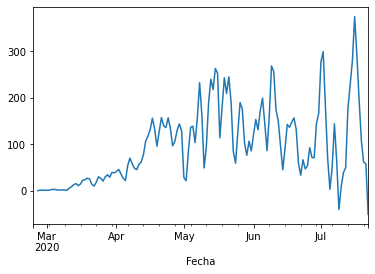

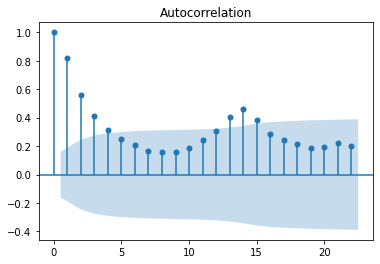

In [210]:
X_sma.diff(periods = 2)[0:150].plot()
adfuller_test(X_sma.diff(periods = 2).dropna()[0:150])
plot_acf(X_sma.diff(periods = 2).dropna()[0:150])
plt.show()

rmse = 2042.9565654187818


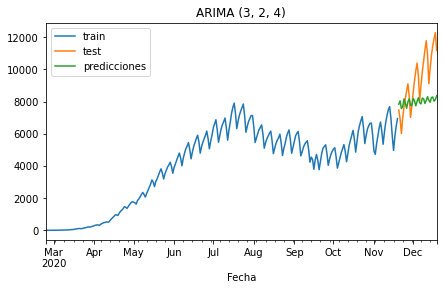

In [235]:
pred0, rmse, test, order = best_model(X_wma[0:300], 30)
print(f'rmse = {rmse}')

rmse = 0.09038070308475599


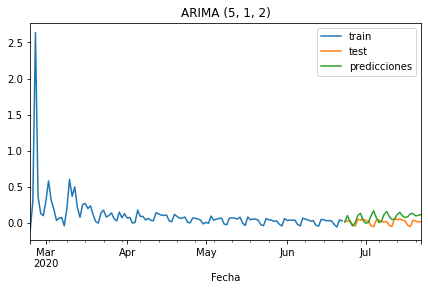

rmse = 12611.503840804886


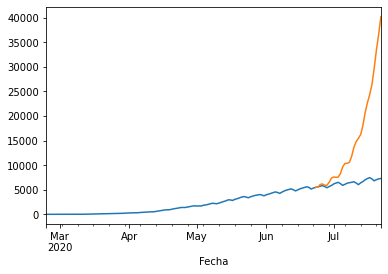

In [204]:
pred, rmse, aic = model_ARIMA(X_inc[0:150], 30, 11,0,2)
pred = pd.Series(pred, index = X_inc[120:150].index)
plot_arima(X_inc[0:120],X_inc[120:150],pred,(5,1,2))
print(f'rmse = {rmse}')
plt.show()

#Eliminamos los incrementos fraccionales
predic1 = eliminar_inc(pred, X_wma[120])
predic1 = pd.Series(predic1, index = X_inc[120:150].index)
X_wma[0:150].plot()
predic1.plot()
rmse = np.sqrt(mean_squared_error(X_wma[120:150],predic1))
print(f'rmse = {rmse}')

rmse = 370.9664553871484


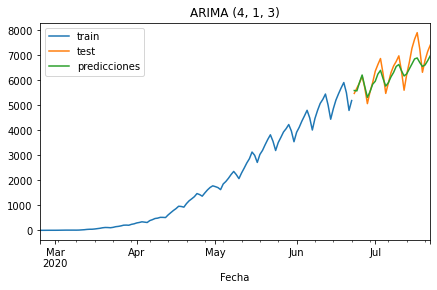

rmse = 496.24688019943244


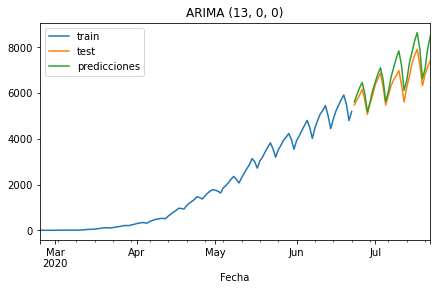

In [238]:
pred, rmse, test, order = best_model(X_wma[0:150], 30)
print(f'rmse = {rmse}')
plt.show()
pred_2, rmse, coefs = model_AR(X_wma[0:150], 30)
print(f'rmse = {rmse}')

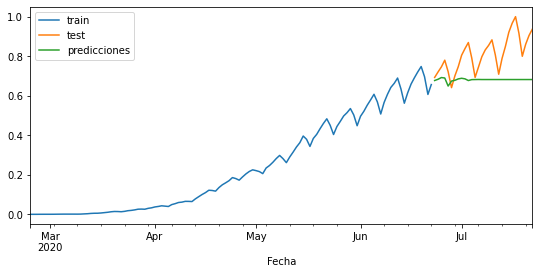

In [251]:
X = X_wma[0:150]/X_wma[0:150].max()
pred, mse, forecaster = train_random_forest(X, steps = 30, plot = True)

<AxesSubplot:xlabel='Fecha'>

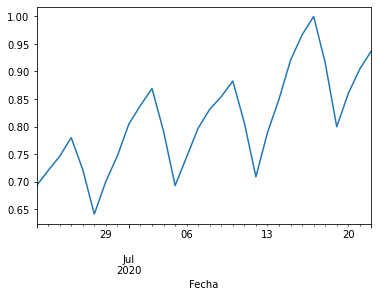

In [248]:
X = X_wma[0:150]/X_wma[0:150].max()
X[-30:].plot()

rmse = 3.7120097117614486


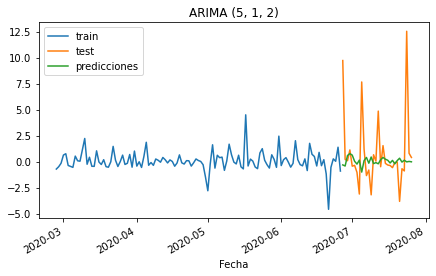

"\npredic1 = eliminar_inc(pred, test[0])\npredic1 = pd.Series(predic1, index = test.index)\nX_sma[0:120].plot()\nX_sma[120:150].plot()\npredic1.plot()\nrmse = np.sqrt(mean_squared_error(test,predic1))\nprint(f'rmse = {rmse}')\n"

In [214]:
steps = 30
train, test = train_test(X_inc_log[0:150], steps)

pred, rmse, aic = model_ARIMA(X_inc_log[0:150], 30, 15,0,1)
pred = pd.Series(pred, index = test.index)
plot_arima(train,test,pred,(5,1,2))

#pred, rmse, test, order = best_model(X_inc_log[0:150], steps)

print(f'rmse = {rmse}')
plt.show()

#Eliminamos los incrementos fraccionales
"""
predic1 = eliminar_inc(pred, test[0])
predic1 = pd.Series(predic1, index = test.index)
X_sma[0:120].plot()
X_sma[120:150].plot()
predic1.plot()
rmse = np.sqrt(mean_squared_error(test,predic1))
print(f'rmse = {rmse}')
"""

rmse = 3.56208353893118


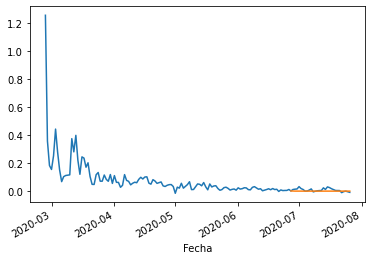

In [180]:
predic1 = eliminar_inc(pred, X_log_sma[120])
predic1 = pd.Series(predic1, index = test.index)
x1 = eliminar_inc(X_inc_log[0:150], X_log_sma[0])
x1 = pd.Series(x1, index = X_inc_log[0:150].index)
x1.plot()
#X_sma[120:150].plot()
predic1.plot()
rmse = np.sqrt(mean_squared_error(test,predic1))
print(f'rmse = {rmse}')

rmse = 1185.0932942651539


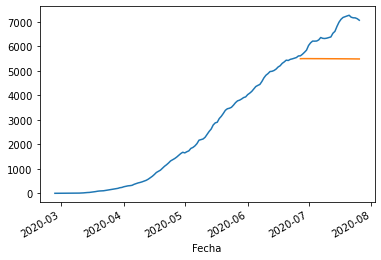

In [181]:
x2 = np.exp(np.cumsum(x1)+X_log[0])
predic2 = np.exp(np.cumsum(predic1) + X_log[120])
x2.plot()
predic2.plot()
rmse = np.sqrt(mean_squared_error(x2[120:150],predic2))
print(f'rmse = {rmse}')

In [120]:
X_sma[X_sma!=0][0]

0.2857142857142857

rmse = 0.013543965688073971


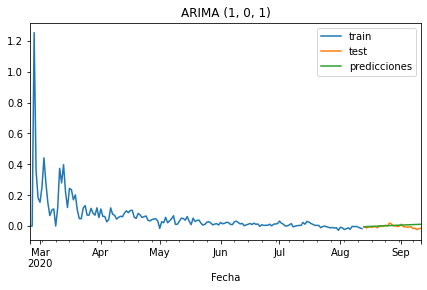

In [78]:
predic, rmse, test, order = best_model(X_log_sma[0:200], 30)
print(f'rmse = {rmse}')

Ahora regresamos a los datos originales

<AxesSubplot:xlabel='Fecha'>

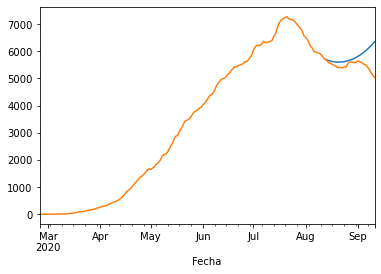

In [199]:
#X_1 = np.cumsum(X_log_sma[0:200])
#X_1.head()
x1 = np.cumsum(X_log_sma[0:200])+X_log[0]
x1 = np.exp(x1)
x2 = np.exp(np.cumsum(predic)+X_log[0:200][-30])
x2.plot()
x1.plot()

In [200]:
x2 = np.cumsum(test)+X_log[0:200][-30]
x2 = np.exp(x2)
print(np.sqrt(mean_squared_error(x2,pred)))

5479.505904919118


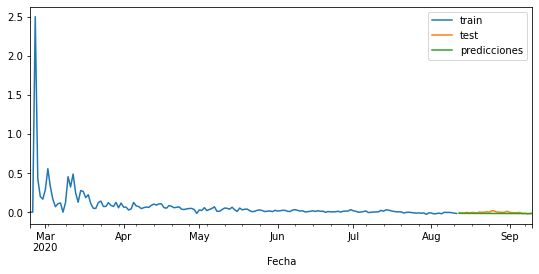

In [219]:
predictions, rmse, test = best_model(X_inc[0:200], 30)

# Segunda ola de casos

rmse = 275.77985130424906


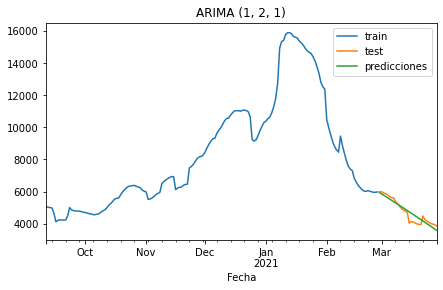

In [224]:
pred, rmse, test, order = best_model(X_sma[200:400], 30)
print(f'rmse = {rmse}')

# Anlizando los casos de covid por estado

In [127]:
errors_rf = []
errors_ar = []
errors_arima = []
params = []
for i in range(32):
    casos_estado = datos_total.iloc[[i]]
    casos_estado = pd.melt(casos_estado, var_name = "Fecha", value_name = "Casos")
    casos_estado["Fecha"] = pd.to_datetime(casos_estado["Fecha"])
    casos_estado = casos_estado.set_index("Fecha")
    casos_estado = casos_estado["Casos"]
    
    estado_sma = casos_estado.rolling(window = 5).mean().dropna()
    #estado_log = np.log(estado_sma.loc[(casos_estado!=0)]).diff(periods = 1).dropna()
    #casos_estado = casos_estado.loc[(casos_estado!=0)]
    #casos_estado = np.log(casos_estado).diff(periods = 1).dropna()
    
    steps = 30
    pred, mse, forecaster_rf = train_random_forest(estado_sma, steps)
    errors_rf.append(mse)
    
    pred, mae, coefs = model_AR(estado_sma, steps, plot = False)
    errors_ar.append(mae)
    
    pred, mae, test, order = best_model(estado_sma, steps, plot = False)
    errors_arima.append(mae)
    params.append(order)

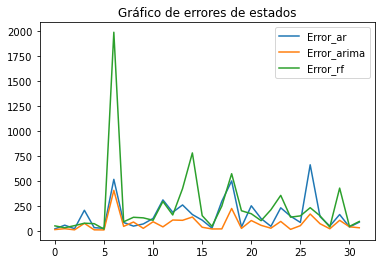

In [182]:
errors = pd.DataFrame({
    "Error_ar": errors_ar,
    "Error_arima": errors_arima,
    "Error_rf": errors_rf})
errors.plot()
plt.title("Gráfico de errores de estados")
plt.savefig("errores.pdf", dpi = 600)

In [133]:
errors

,Error_ar,Error_arima,Error_rf
0,23.865412,16.704156,53.571291
1,60.554079,25.654012,34.937260
2,25.314957,14.050461,56.131128
3,209.417451,78.737618,80.231532
4,35.954789,14.007228,75.667247
5,28.831908,13.288659,21.583537
6,517.730480,407.493784,1985.359616
7,87.516880,48.584709,94.406521
8,51.215335,92.173507,139.362426
9,72.789794,29.048345,133.643523


In [180]:
params

[(4, 0, 3),
 (3, 0, 3),
 (4, 2, 3),
 (2, 0, 0),
 (0, 2, 0),
 (3, 2, 3),
 (4, 2, 3),
 (3, 0, 3),
 (4, 2, 2),
 (2, 2, 0),
 (2, 0, 4),
 (4, 2, 2),
 (2, 0, 0),
 (4, 2, 0),
 (4, 2, 3),
 (4, 2, 0),
 (4, 0, 3),
 (3, 2, 0),
 (1, 0, 1),
 (4, 2, 4),
 (1, 0, 1),
 (3, 0, 4),
 (3, 2, 0),
 (4, 2, 0),
 (4, 2, 2),
 (4, 2, 2),
 (2, 0, 0),
 (3, 0, 3),
 (4, 0, 3),
 (1, 0, 4),
 (2, 1, 2),
 (2, 0, 0)]

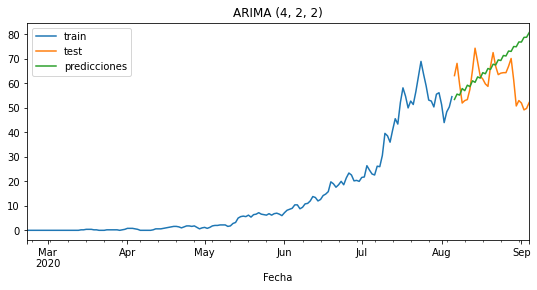

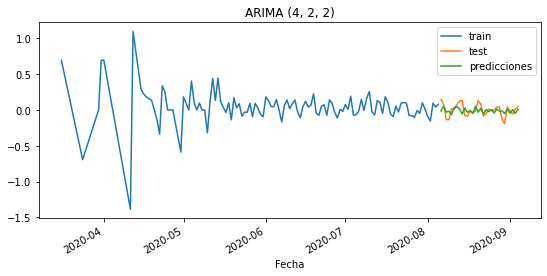

In [138]:
n = 8
casos_estado = datos_total.iloc[[n]]
casos_estado = pd.melt(casos_estado, var_name = "Fecha", value_name = "Casos")
casos_estado["Fecha"] = pd.to_datetime(casos_estado["Fecha"])
casos_estado = casos_estado.set_index("Fecha")
casos_estado = casos_estado["Casos"]

estado_sma = casos_estado[0:200].rolling(window = 5).mean().dropna()
estado_log = np.log(estado_sma.loc[(casos_estado!=0)]).diff(periods = 1).dropna()

train, test = train_test(estado_sma, 30)
pred, rmse, aic = model_ARIMA(estado_sma, 30, params[n][0], params[n][1], params[n][2])
pred = pd.Series(pred, index = test.index) 
plot_arima(train, test, pred, params[n])

train, test = train_test(estado_log, 30)
pred, rmse, aic = model_ARIMA(estado_log, 30, 12, 1, 2)#params[n][0], params[n][1], params[n][2])
pred = pd.Series(pred, index = test.index) 
plot_arima(train, test, pred, params[n])

<AxesSubplot:xlabel='Fecha'>

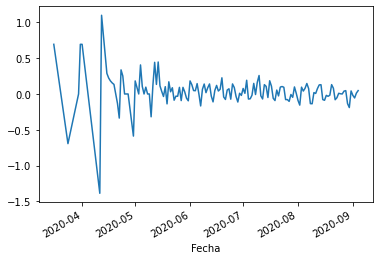

In [99]:
estado_log = np.log(estado_sma.loc[(casos_estado!=0)]).diff(periods = 1).dropna()
estado_log.plot()

4.026779611569435


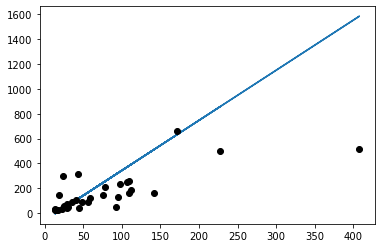

In [146]:
m = np.polyfit(errors_arima, errors_rf,1)
plt.plot(errors_arima, np.polyval(m, errors_arima))
plt.plot(errors_arima,errors_ar, "ko")
print(m[0])

In [141]:
datos = pd.read_csv(path + "\datos_covid\Casos_Diarios_Estado_Nacional_Confirmados_20210908.csv", sep = ',')
datos.head()

,cve_ent,poblacion,nombre,18/02/2020,19/02/2020,20/02/2020,21/02/2020,22/02/2020,23/02/2020,24/02/2020,...,31/08/2021,01/09/2021,02/09/2021,03/09/2021,04/09/2021,05/09/2021,06/09/2021,07/09/2021,08/09/2021,total
0,1,1434635,AGUASCALIENTES,0,0,0,0,0,0,0,...,106,98,146,120,17,19,89,32,0,31965
1,2,3634868,BAJA CALIFORNIA,0,0,0,0,0,0,0,...,111,123,127,108,34,33,121,62,0,57803
2,3,804708,BAJA CALIFORNIA SUR,0,0,0,0,0,0,0,...,87,78,86,47,24,14,76,49,0,54208
3,4,1000617,CAMPECHE,0,0,0,0,0,0,0,...,201,184,165,88,56,55,110,36,0,20997
4,7,5730367,CHIAPAS,0,0,0,0,0,0,0,...,96,92,77,74,49,37,63,34,0,20569


In [143]:
poblacion = datos["poblacion"]
total = datos["total"]

0.7926786437708624


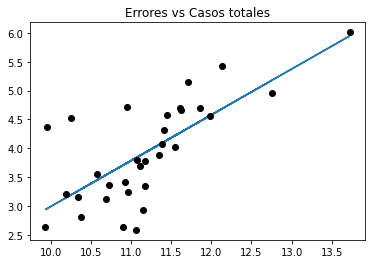

In [232]:
log_error = np.log(errors_arima)
log_total = np.log(total[:-1])

m = np.polyfit(log_total,log_error,1)
plt.plot(log_total, np.polyval(m, log_total))
plt.plot(log_total, log_error, "ko")
plt.title("Errores vs Casos totales")
plt.savefig("errores_poblacion.pdf",dpi=500)
print(m[0])

0.5619145043253305


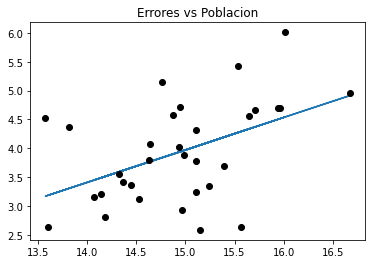

In [234]:
log_error = np.log(errors_arima)
log_poblacion = np.log(poblacion[:-1])

m = np.polyfit(log_poblacion,log_error,1)
plt.plot(log_poblacion, np.polyval(m, log_poblacion))
plt.plot(log_poblacion, log_error, "ko")
plt.title("Errores vs Poblacion")
plt.savefig("errores_poblacion.pdf",dpi=500)
print(m[0])

In [173]:
def coeficiente_corr(x,y):
    x_mean = x - np.mean(x)
    y_mean = y - np.mean(y)
    suma_x = 0
    for i in x_mean:
        suma_x = suma_x+i*i
    suma_y=0
    for i in y_mean:
        suma_y = suma_y+i*i
    r = np.sum(x_mean*y_mean)/np.sqrt(suma_y*suma_x)
    return r

In [233]:
print(coeficiente_corr(log_total,log_error))

0.7151901390086455


In [235]:
print(coeficiente_corr(log_poblacion,log_error))

0.4718172586562296
